## 🐬 Описание проекта


*   Исследование проводилось для кадрового агентства, предоставившего данные по закрытию вакансий за период 2023 - начало 2024 года.
*   Цель (формулировка в ТЗ)
Выявить признаки вакансий, привлекающих наибольшее внимание кандидатов и успешно закрывающихся силами агентства. В рамках выполнения данной задачи можно использовать любые методы и средства, даже если они не описаны в ТЗ.







## 🪼В этом ноутбуке продолжение [исследований](https://docs.google.com/spreadsheets/d/1HjNH6JRjQz9TJ_6DcXCofrh4xAIzBE84/edit?usp=drive_link&ouid=108036727568364940970&rtpof=true&sd=true), проведенных Марией и попытка немного по-другому обработать категориальные и текстовые признаки

Основные отличия:
- мультилейбл для типа занятости, образования, опыта и формата работы
- уменьшение числа уникальных значений для городов
- убрать курсы из признаков (насколько можно понять - это служебная информация, которую кандидат не видит)
- tiny bert  вместо bert. В дальнейшем можно попробовать прикрутить суммаризацию, чтобы исключить повторы
- тестовое задание - есть/нет
- для названия позиции введена дополнительная фича - грейд
- метод кластеризации по профессиям -  оставлен ручной с небольшими модификациями
- города - разделены на наиболее крупные и все остальные, исключены неявные дубликаты

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip -q install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.3 MB/s eta 0:00:00


In [3]:
# !pip -q install pymorphy2

In [4]:
import pandas as pd
import warnings
import copy
import re
import os
import numpy as np
import torch
from tqdm import tqdm
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
# import pymorphy2
# from pymorphy2 import MorphAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import joblib
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from pymystem3 import Mystem


import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


RANDOM_STATE = 2004
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')

sns.set(style='darkgrid', font_scale=1.2)

In [5]:
# import nltk
# nltk.download('punkt')
# from nltk.tokenize import word_tokenize

# nltk.download('stopwords')
# from nltk.corpus import names, stopwords, words
# from wordcloud import WordCloud, STOPWORDS
# STOPWORDS = set(stopwords.words('russian'))
# nltk.download('wordnet')
# from nltk.stem import WordNetLemmatizer

## 🐚 Загрузка данных

In [6]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/vacancies/vacancy_statistics_2023.xlsx', index_col=False)

In [7]:
df.sample(5)

,id,Статус,Источник лида,Менеджер,Дата публикации,Дата закрытия,Количество просмотров,Количество откликов,Компания,Позиция,Курсы ЯП,Зарплата от,Зарплата до,Город,Формат оформления,Формат работы,Опыт,Образование,Ссылка на тестовое,Занятость,Обязательные требования,Дополнительный требования,Этапы отбора,Условия
851,1465,Архив,Повторная,Фаткуллин,2023-08-15,2023-09-28,26,6,ООО Лигал ДД,Python-разработчик,"Python-разработчик плюс, Python-Разработчик",NaN,NaN,Москва,Самозанятость,Удаленка,"Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,"Стажировка, Проектная",Python _x000D_\nRest API _x000D_\nDjangoP Djan...,NaN,1. Скрининг резюме _x000D_\n2. Собеседование с...,Удаленка_x000D_\nПрактика для опыта _x000D_\nП...
1209,1954,Акселерация,Входящая заявка,Фаткуллин,2023-11-20,NaN,12,4,Фонд Сколково,Младший менеджер по маркетингу,"Трафик-менеджер, Интернет маркетолог",NaN,NaN,Москва,"ИП, ГПХ, Самозанятость, Контракт, Трудовой дог...","Офис, Гибрид","Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,Полная,"Знание и опыт в разработке стратегии продукта,...",NaN,1. Скрининг резюме _x000D_\n2. Собеседование,Трудоустройство в соответствии с ТК РФ;_x000D_...
712,1256,Архив,Повторная,Фаткуллин,2023-07-19,2023-08-25,9,1,#IZUM,Интернет-маркетолог,"Трафик-менеджер, Интернет маркетолог",40000.0,140000.0,Москва,Трудовой договор,"Офис, Гибрид","Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,"Частичная, Полная",Обладаете образованием и/или проходили соответ...,Готовность брать ответственность на себя.,1. Телефонное интервью._x000D_\n2. Собеседован...,Работа в офисе полный день будет преимуществом...
542,1005,Архив,Сорсинг,Селиверстова,2023-06-09,2023-10-27,31,4,ПроКонтекст,Интернет-маркетолог,"Трафик-менеджер, Специалист по контекстной рек...",40000.0,40000.0,Москва,Трудовой договор,"Офис, Удаленка","Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,Полная,- высшее образование (важен факт наличия дипло...,- высшее образование в технической сфере;_x000...,1. Отклик в Карьерном Трекере. _x000D_\n2. Скр...,- официальное оформление по ТК РФ;_x000D_\n- р...
290,651,Архив,Реферальная,Игнатенко,2023-04-05,2023-04-12,33,21,Локальная компания,Frontend-разработчик (React),"Web Bootcamp, React-разработчик, Веб-Разработч...",NaN,NaN,Санкт-Петербург,"ИП, ГПХ, Самозанятость, Контракт, Трудовой дог...","Офис, Гибрид, Удаленка","Около-релевантный (Pet-проекты, open-source, в...","Другое, Около-релевантное (например, техническ...",NaN,"Волонтерство, Проектная, Частичная, Стажировка...",- хорошее знание React_x000D_\n- желание учиться,"- знание Vue, если не знаете, научим",- скрининг_x000D_\n- интервью,- можно на полную или частичную занятость_x000...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1302 non-null   int64  
 1   Статус                     1302 non-null   object 
 2   Источник лида              1292 non-null   object 
 3   Менеджер                   1209 non-null   object 
 4   Дата публикации            1302 non-null   object 
 5   Дата закрытия              1144 non-null   object 
 6   Количество просмотров      1302 non-null   int64  
 7   Количество откликов        1302 non-null   int64  
 8   Компания                   1302 non-null   object 
 9   Позиция                    1302 non-null   object 
 10  Курсы ЯП                   1302 non-null   object 
 11  Зарплата от                476 non-null    float64
 12  Зарплата до                377 non-null    float64
 13  Город                      1302 non-null   objec

In [9]:
df=df.rename(columns={'Статус':'status', 'Источник лида':'lead_source', 'Менеджер':'manager', 'Дата публикации':'start_date', 'Дата закрытия':'end_date', 'Количество просмотров':'views',
'Количество откликов':'responses', 'Компания':'emp_brand',  'Позиция':'job_title', 'Курсы ЯП':'courses','Зарплата от':'salary_min', 'Зарплата до':'salary_max', 'Город':'city', 'Формат оформления':'contract', 'Формат работы':'format', 'Опыт':'experience', 'Образование':'education', 'Занятость':'employment', 'Ссылка на тестовое':'test_task', 'Обязательные требования':'mandatory', 'Дополнительный требования':'additional', 'Этапы отбора':'comр_stages', 'Условия':'work_conditions'
})

In [10]:
df['target'] = df['responses'] / df['views']

In [11]:
df['test_task'] = df['test_task'].apply(lambda x: 1 if (x is not None) else 0)

In [12]:
df = df.drop(columns=['id','status','lead_source','manager', 'start_date', 'end_date', 'views', 'responses', 'courses'], axis=1)

In [13]:
df['emp_brand'] = df['emp_brand'].apply(lambda x: x.lower().strip())

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   emp_brand        1302 non-null   object 
 1   job_title        1302 non-null   object 
 2   salary_min       476 non-null    float64
 3   salary_max       377 non-null    float64
 4   city             1302 non-null   object 
 5   contract         1302 non-null   object 
 6   format           1302 non-null   object 
 7   experience       1302 non-null   object 
 8   education        1302 non-null   object 
 9   test_task        1302 non-null   int64  
 10  employment       1302 non-null   object 
 11  mandatory        1302 non-null   object 
 12  additional       674 non-null    object 
 13  comр_stages      1302 non-null   object 
 14  work_conditions  1302 non-null   object 
 15  target           1302 non-null   float64
dtypes: float64(3), int64(1), object(12)
memory usage: 162.9+ KB


## 🦈 Профессии и грейды

In [15]:
def grade(txt: str) -> str:
    grds = ['intern', 'juniour', 'middle', 'senior', 'lead']
    patterns = [['intern', 'интерн', 'стаж', 'ассист', 'помощ'],
                ['juni', 'младш', 'джун'],
                 ['middle', 'мидл', 'средн'],
                 ['senior', 'сеньор', 'старш'],
                  ['lead', 'ведущ', 'тимлид']]
    result = 'unknown'
    for g, p in zip(grds, patterns):
        matches = [x for x in p if x in txt.lower()]
        if len(matches) != 0:
            result = g
            pass # first match
    return result

In [16]:
df['grade'] = df['job_title'].apply(grade)

<Axes: >

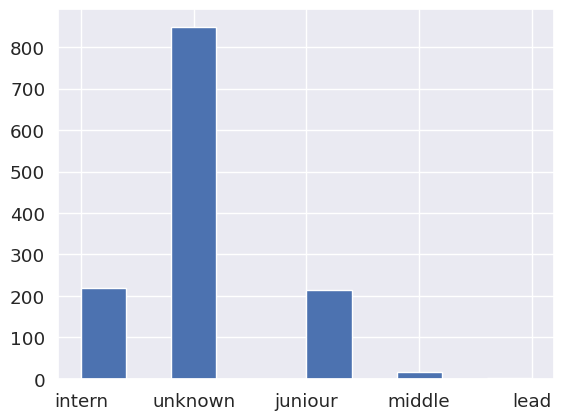

In [17]:
df['grade'].hist()

In [18]:
def prof(txt: str) -> str:
    profs = ['developer', 'devops', 'ds', 'analyst', 'manager',
             'tester', 'designer', 'marketolog', 'support', 'hr']
    patterns = [['develop', 'разработ', 'программист'],
                ['devops', 'ops'],
                 ['ds', 'scien', 'саен', 'сайен', 'ml', 'nlp', 'машин'],
                 ['аналит', 'analyst', 'данны'],
                  ['pm', 'менеджер', 'руководитель', 'manager', 'куратор', 'администр'],
                ['качеств', 'тест', 'test', 'qa'],
                ['design', 'ux', 'ui', 'дизайн'],
                ['таргет', 'market', 'маркет', 'контекст', 'smm', 'seo'],
                ['support', 'техподдер', 'поддерж', 'забот'],
                ['recruit', 'hr', 'сорсер', 'рекрут', 'ресечер', 'рисерчер']]
    result = 'other'
    for pr, pt in zip(profs, patterns):
        matches = [x for x in pt if x in txt.lower()]
        if len(matches) != 0:
            result = pr
            pass
    return result

In [19]:
df['profession'] = df['job_title'].apply(prof)

In [20]:
df = df.drop(['job_title'], axis=1)

## 🐙 Города

Строго говоря, сюда надо подтягивать geopandas и geonames. Пока что в качестве временной меры сделаем категории Москва, СПб, Екб и все остальное

In [21]:
def outside_the_mkad(txt: str) -> str:
    patterns = [['москв', 'маскв', 'москов'],
                ['петерб', 'санкт', 'спб', 'питер'],
                ['екб', 'екатеринб']]
    cities = ['MOW', 'LED', 'SVX']
    result = 'other'
    for c, pt in zip(cities, patterns):
        matches = [x for x in pt if x in txt.lower()]
        if len(matches) != 0:
            result = c
            pass
    return result

In [22]:

df['location'] = df['city'].apply(outside_the_mkad)

<Axes: >

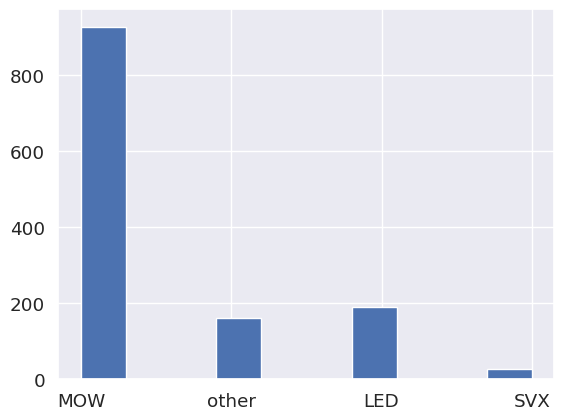

In [23]:
df['location'].hist()

In [24]:
df = df.drop(['city'], axis=1)

## 🪸 Опыт, образования, условия работы

In [25]:
def labels(data: pd.DataFrame, column: str):
    vals = data[column].unique()
    all_vals = ','.join(list(vals))
    all_vals = re.sub(r'\((.*?)\)', r'', all_vals).split(',')
    all_vals = list(map(lambda x: x.strip(), all_vals))
    un_vals = list(set(all_vals))
    for u in un_vals:
        data[u] = data[column].apply(lambda x: 1 if u in x else 0)

In [26]:
labels(df, 'experience')

In [27]:
df = df.rename(columns={'Релевантный': 'relevant_exp',
                   'Около-релевантный': 'near_exp',
                   'Есть только учебный опыт в Практикуме': 'student_exp'})
df = df.drop(['experience'], axis=1)

In [28]:
labels(df, 'education')

In [29]:
df = df.rename(columns={'Профильное': 'relevant_edu',
                   'Около-релевантное': 'near_edu',
                   'Другое': 'other_edu'})
df = df.drop(['education'], axis=1)

In [30]:
labels(df, 'format')

In [31]:
labels(df, 'contract')

In [32]:
df = df.rename(columns={'Удаленка': 'remote',
                   'Офис': 'office',
                   'Гибрид': 'hybrid',
                        'ГПХ': 'gph',
                        'Контракт': 'temporary',
                        'Трудовой договор': 'permanent',
                        'Самозанятость': 'self_empl',
                        'ИП': 'ind_enterp'})
df = df.drop(['format', 'contract'], axis=1)

In [33]:
labels(df, 'employment')

In [34]:
df = df.rename(columns={'Проектная': 'project',
                   'Частичная': 'part_time',
                   'Полная': 'full_time',
                        'Стажировка': 'internship',
                        'Волонтерство': 'volunteering'})
df = df.drop(['employment'], axis=1)

## 🐡 Заполнение пропусков

In [35]:
df['additional']= df['additional'].fillna(' или ')

In [36]:
# df['salary_min'] = df.groupby("profession")['salary_min'].transform(lambda x: x.fillna(x.median()))
# df['salary_max'] = df.groupby("profession")['salary_max'].transform(lambda x: x.fillna(x.median()))

In [37]:
df['description'] = df['mandatory'] + df['additional'] + df['comр_stages'] + df['work_conditions']
df['emp_brand'] = df['emp_brand'] + ' '
df['description_1'] = df['emp_brand'] + df['mandatory'] + df['additional'] + df['comр_stages'] + df['work_conditions']
df = df.drop(['mandatory', 'additional', 'comр_stages', 'work_conditions'], axis=1)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   emp_brand      1302 non-null   object 
 1   salary_min     476 non-null    float64
 2   salary_max     377 non-null    float64
 3   test_task      1302 non-null   int64  
 4   target         1302 non-null   float64
 5   grade          1302 non-null   object 
 6   profession     1302 non-null   object 
 7   location       1302 non-null   object 
 8   relevant_exp   1302 non-null   int64  
 9   near_exp       1302 non-null   int64  
 10  student_exp    1302 non-null   int64  
 11  relevant_edu   1302 non-null   int64  
 12  near_edu       1302 non-null   int64  
 13  other_edu      1302 non-null   int64  
 14  remote         1302 non-null   int64  
 15  office         1302 non-null   int64  
 16  hybrid         1302 non-null   int64  
 17  ind_enterp     1302 non-null   int64  
 18  temporar

## 🦭 Text Processing (Tiny Bert)

---



In [39]:
def cleaner(txt: str) -> str:
    txt = re.sub(r'\_(.*?)\_', r'', txt)
    txt = re.sub(r'([\n\t]*)', r'', txt)
    return txt

In [40]:
example = df['description'][154]
print(example)
print('_'*50)
cleaner(example)

Кого мы ищем:_x000D_
_x000D_
- Мистера или Мисс Обаяние, самого очаровательного рекрутера;_x000D_
- Настойчивого, но ненавязчивого, любящего людей человека;_x000D_
- Рекрутера с опытом в подборе ИЛИ кандидата без опыта, жаждущего влиться в новый увлекательный мир IT-подбора;_x000D_
- Разговорный английский от B1-B2 обязателен. или - Телефонный созвон с HRD _x000D_
- Интервью в zoom с командой_x000D_
Если тебя заинтересовала наша вакансия, пожалуйста, расскажи о своем самом большом профессиональном достижении в сопроводительном письме.- Мы не берем в работу неконкурентоспособные вакансии. - Никаких зарплат ниже рынка, скучных задач и мертвых стеков. _x000D_
- Удаленка, оплата в долларах, релокейт - мы выбираем только такие позиции;_x000D_
- Возможность познакомиться с системами подбора лучших компаний мира;_x000D_
- Мы обучаем сами и привлекаем спикеров со стороны, чтобы усилить скиллы наших рекрутеров;_x000D_
- Мы достойно оплачиваем работу: рекрутер получает оклад, а также от 10 до 25

'Кого мы ищем:- Мистера или Мисс Обаяние, самого очаровательного рекрутера;- Настойчивого, но ненавязчивого, любящего людей человека;- Рекрутера с опытом в подборе ИЛИ кандидата без опыта, жаждущего влиться в новый увлекательный мир IT-подбора;- Разговорный английский от B1-B2 обязателен. или - Телефонный созвон с HRD - Интервью в zoom с командойЕсли тебя заинтересовала наша вакансия, пожалуйста, расскажи о своем самом большом профессиональном достижении в сопроводительном письме.- Мы не берем в работу неконкурентоспособные вакансии. - Никаких зарплат ниже рынка, скучных задач и мертвых стеков. - Удаленка, оплата в долларах, релокейт - мы выбираем только такие позиции;- Возможность познакомиться с системами подбора лучших компаний мира;- Мы обучаем сами и привлекаем спикеров со стороны, чтобы усилить скиллы наших рекрутеров;- Мы достойно оплачиваем работу: рекрутер получает оклад, а также от 10 до 25% от оклада нанятого разработчика;- Полностью удаленная работа;- Мы веселые и экологичн

In [41]:
df['description'] = df['description'].apply(cleaner)

In [42]:
df['description_1'] = df['description_1'].apply(cleaner)

In [43]:
df['seqlen'] = df['description'].apply(lambda x: len(x))
q1 = df['seqlen'].quantile(.05)
q2 = df['seqlen'].quantile(.95)
df = df.loc[(df['seqlen'] > q1) & (df['seqlen'] < q2)]
df['seqlen'].describe()

count    1170.000000
mean      823.358974
std       297.216041
min       307.000000
25%       583.000000
50%       796.000000
75%      1054.000000
max      1488.000000
Name: seqlen, dtype: float64

In [44]:
df = df.drop(['seqlen'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1170 entries, 0 to 1301
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   emp_brand      1170 non-null   object 
 1   salary_min     425 non-null    float64
 2   salary_max     337 non-null    float64
 3   test_task      1170 non-null   int64  
 4   target         1170 non-null   float64
 5   grade          1170 non-null   object 
 6   profession     1170 non-null   object 
 7   location       1170 non-null   object 
 8   relevant_exp   1170 non-null   int64  
 9   near_exp       1170 non-null   int64  
 10  student_exp    1170 non-null   int64  
 11  relevant_edu   1170 non-null   int64  
 12  near_edu       1170 non-null   int64  
 13  other_edu      1170 non-null   int64  
 14  remote         1170 non-null   int64  
 15  office         1170 non-null   int64  
 16  hybrid         1170 non-null   int64  
 17  ind_enterp     1170 non-null   int64  
 18  temporary    

In [45]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

def embed_bert_cls(text):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls(example).shape)

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

(312,)


In [46]:
# emb_result = np.array(list(map(lambda x: 'emb_' + str(x), range(312))))
# emb_result = np.expand_dims(emb_result, axis=0)
# for data in tqdm(df['description'].values, desc='Creating embeddings'):
#     res = np.expand_dims(embed_bert_cls(data), axis=0)
#     emb_result = np.concatenate((emb_result, res), axis=0)

In [47]:
# emb_result.shape

In [48]:
# dfe = pd.DataFrame(data=emb_result[1:,:], columns=emb_result[0,:])
# dfe.head()

In [49]:
class VacClass(Dataset):
    def __init__(self, annotations, thr: list):
        self.annotations = annotations
        self.threshold = thr

    def __getitem__(self, idx):
        txt_ = self.annotations['description_1'].values[idx]
        target = self.annotations['target'].values[idx]
        if target < self.threshold[0]:
            target = 0
        elif self.threshold[0] < target < self.threshold[1]:
            target = 1
        else:
            target = 2
        return [txt_], torch.tensor(target)

    def __len__(self):
        return len(self.annotations)

<Axes: >

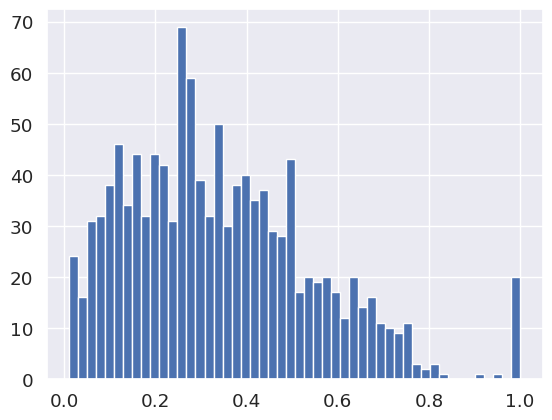

In [50]:
df['target'].hist(bins=50)

In [51]:
def cl(score: float):
    if score < .2:
        return 0
    elif .2 < score < .4:
        return 1
    else:
        return 2
df['classes'] = df['target'].apply(cl)
w = []
for c in df['classes'].unique():
    w.append(len(df.loc[df['classes'] == c]) / len(df))

weights = torch.FloatTensor(w)
weights

tensor([0.3530, 0.2641, 0.3829])

In [52]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device:', device)
SEED = torch.Generator().manual_seed(RANDOM_STATE)
BATCH_SIZE = 32

device: cpu


In [53]:
vac = VacClass(df, [.22, .66])
train_ru, valid_ru = torch.utils.data.random_split(vac, [.8, .2], generator=SEED)
train_dataloader_ru = torch.utils.data.DataLoader(train_ru, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader_ru = torch.utils.data.DataLoader(valid_ru, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [54]:
class TransformerRegrModel(nn.Module):
    def __init__(self, base_transformer_model: str, num_classes: int):
        super().__init__()
        self.tr_model = base_transformer_model
        self.num = num_classes

        if self.tr_model not in  ['rubert', 'base']:
            raise Exception('unknown model')
        elif self.tr_model == 'rubert':
            self.tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
            self.config = BertConfig.from_pretrained("cointegrated/rubert-tiny2", output_hidden_states=True, output_attentions=True)
        elif self.tr_model == 'base':
            self.tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base", model_max_length=512)
            self.config = BertConfig.from_pretrained("ai-forever/ruBert-base", output_hidden_states=True, output_attentions=True)
        self.model = AutoModel.from_config(self.config)
        self.a1 = nn.ReLU()
        self.classifier_1 = nn.Linear(self.model.pooler.dense.out_features, 128)
        self.classifier_dropout = nn.Dropout(p=0.2)
        self.classifier_2 = nn.Linear(128, self.num)

    def forward(self, inputs):
        t = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='pt')
        tokens = self.tokenizer.convert_ids_to_tokens(t['input_ids'][0])
        model_output = self.model(**{k: v.to(device) for k, v in t.items()})
        attentions = torch.cat(model_output['attentions']).to('cpu')
        embeddings = model_output.last_hidden_state[:, 0, :]
        embeddings = torch.nn.functional.normalize(embeddings)
        outputs = self.a1(embeddings)
        outputs = self.classifier_1(outputs)
        outputs = self.classifier_dropout(outputs)
        outputs = self.a1(outputs)
        outputs = self.classifier_dropout(outputs)
        outputs = self.classifier_2(outputs)

        return outputs, tokens, attentions

In [55]:
rubert = TransformerRegrModel('rubert', 3)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

In [56]:
txts, labels = next(iter(train_dataloader_ru))
rubert.to(device)
rubert.eval()
res, tokens, attentions = rubert(txts[0])
res

tensor([[-0.0301,  0.0471, -0.0218],
        [-0.0298,  0.0472, -0.0215],
        [-0.0299,  0.0474, -0.0213],
        [-0.0300,  0.0471, -0.0213],
        [-0.0302,  0.0473, -0.0213],
        [-0.0299,  0.0471, -0.0216],
        [-0.0299,  0.0472, -0.0214],
        [-0.0299,  0.0471, -0.0214],
        [-0.0300,  0.0472, -0.0214],
        [-0.0299,  0.0474, -0.0214],
        [-0.0300,  0.0470, -0.0215],
        [-0.0299,  0.0472, -0.0214],
        [-0.0301,  0.0473, -0.0212],
        [-0.0301,  0.0472, -0.0213],
        [-0.0299,  0.0471, -0.0215],
        [-0.0300,  0.0471, -0.0214],
        [-0.0300,  0.0472, -0.0213],
        [-0.0300,  0.0473, -0.0212],
        [-0.0298,  0.0474, -0.0213],
        [-0.0301,  0.0470, -0.0215],
        [-0.0298,  0.0471, -0.0212],
        [-0.0300,  0.0472, -0.0212],
        [-0.0300,  0.0472, -0.0213],
        [-0.0301,  0.0472, -0.0214],
        [-0.0299,  0.0473, -0.0215],
        [-0.0301,  0.0474, -0.0215],
        [-0.0300,  0.0471, -0.0215],
 

In [57]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler_down, scheduler_up):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:

        # inputs = inputs[0].to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs, _, _ = model(inputs[0])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * len(inputs[0])
        running_corrects += torch.sum(preds == labels.data)
        processed_data += len(inputs[0])

    scheduler_down.step()
    # scheduler_up.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    rate = optimizer.param_groups[0]["lr"]
    return train_loss, train_acc, rate


In [58]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        # inputs = inputs[0].to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs, _, _ = model(inputs[0])
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * len(inputs[0])
        running_corrects += torch.sum(preds == labels.data)
        processed_size += len(inputs[0])
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [59]:
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels in test_loader:
            labels = labels.to(device)
            model.eval()
            outputs, _, _ = model(inputs[0])
            logits.append(outputs.cpu())
            preds.append(torch.argmax(outputs, 1).cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += len(inputs[0])

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.cpu().numpy() / processed_size
    return answers, preds, probs, test_acc

In [60]:
def vizualize(h, model):
    loss, acc, val_loss, val_acc, rate = zip(*h)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()
    plt.plot(np.log(rate), label="learning_rate", color='green')
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("learning rate (log scale)")
    plt.show()

In [61]:
def freeze_model(model):
    for name, param in model.named_parameters():
        if 'classifier' not in name:
            param.requires_grad = False
    return model

In [62]:
def train_transformer(train, val, model, epochs, rate, criterion, freeze):
    model_ = copy.copy(model)
    if freeze:
        model_ = freeze_model(model_)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}, learning rate {r}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model_.parameters(), lr=rate)
        # sch = StepLR(opt, step_size=5, gamma=0.1)
        sch_down = StepLR(opt, step_size=25, gamma=0.2)
        sch_up = StepLR(opt, step_size=10, gamma=200)

        val_acc_p = 0

        for epoch in range(epochs):
            train_loss, train_acc, rate = fit_epoch(model_, train, criterion, opt, sch_down, sch_up)

            val_loss, val_acc = eval_epoch(model_, val, criterion)
            if val_acc > val_acc_p and epoch != 0:
                torch.save(model_.state_dict(), "/content/drive/MyDrive/Colab Notebooks/vacancies/tiny.pt")
                print(f'save best model for {epoch} epoch')
                val_acc_p = val_acc
            history.append((train_loss, train_acc, val_loss, val_acc, rate))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, r=rate))

    return history, model_

In [63]:
bce = nn.CrossEntropyLoss(weight=weights.to(device))
lr = 3e-4

In [ ]:
rubert = rubert.to(device)
graphs, trained_model = train_transformer(train_dataloader_ru, valid_dataloader_ru,
                                                                rubert, epochs=75,
                                                                rate=lr, criterion=bce, freeze=False)

epoch:   2%|▏         | 1/45 [00:20<14:52, 20.29s/it]


Epoch 001 train_loss: 1.0341     val_loss 0.9952 train_acc 0.4893 val_acc 0.6282, learning rate 0.0003


epoch:   4%|▍         | 2/45 [00:39<14:04, 19.63s/it]

save best model for 1 epoch

Epoch 002 train_loss: 0.9894     val_loss 0.9505 train_acc 0.6068 val_acc 0.6282, learning rate 0.0003


epoch:   7%|▋         | 3/45 [00:58<13:27, 19.23s/it]


Epoch 003 train_loss: 0.9593     val_loss 0.9213 train_acc 0.6090 val_acc 0.6282, learning rate 0.0003


epoch:   9%|▉         | 4/45 [01:16<12:56, 18.93s/it]


Epoch 004 train_loss: 0.9458     val_loss 0.9058 train_acc 0.6090 val_acc 0.6282, learning rate 0.0003


epoch:  11%|█         | 5/45 [01:35<12:31, 18.80s/it]


Epoch 005 train_loss: 0.9386     val_loss 0.8996 train_acc 0.6090 val_acc 0.6282, learning rate 0.0003


epoch:  13%|█▎        | 6/45 [01:53<12:11, 18.76s/it]


Epoch 006 train_loss: 0.9274     val_loss 0.9371 train_acc 0.6100 val_acc 0.6282, learning rate 0.0003


epoch:  16%|█▌        | 7/45 [02:12<11:48, 18.65s/it]


Epoch 007 train_loss: 0.8639     val_loss 0.9135 train_acc 0.7382 val_acc 0.5726, learning rate 0.0003


epoch:  18%|█▊        | 8/45 [02:30<11:27, 18.59s/it]


Epoch 008 train_loss: 0.6958     val_loss 0.9960 train_acc 0.8590 val_acc 0.5385, learning rate 0.0003


epoch:  20%|██        | 9/45 [02:49<11:10, 18.63s/it]


Epoch 009 train_loss: 0.5976     val_loss 1.1364 train_acc 0.8611 val_acc 0.5556, learning rate 0.0003


epoch:  22%|██▏       | 10/45 [03:08<10:50, 18.57s/it]


Epoch 010 train_loss: 0.5680     val_loss 1.3473 train_acc 0.8643 val_acc 0.4701, learning rate 0.0003


epoch:  24%|██▍       | 11/45 [03:26<10:28, 18.50s/it]


Epoch 011 train_loss: 0.4991     val_loss 1.2341 train_acc 0.8878 val_acc 0.5855, learning rate 0.0003


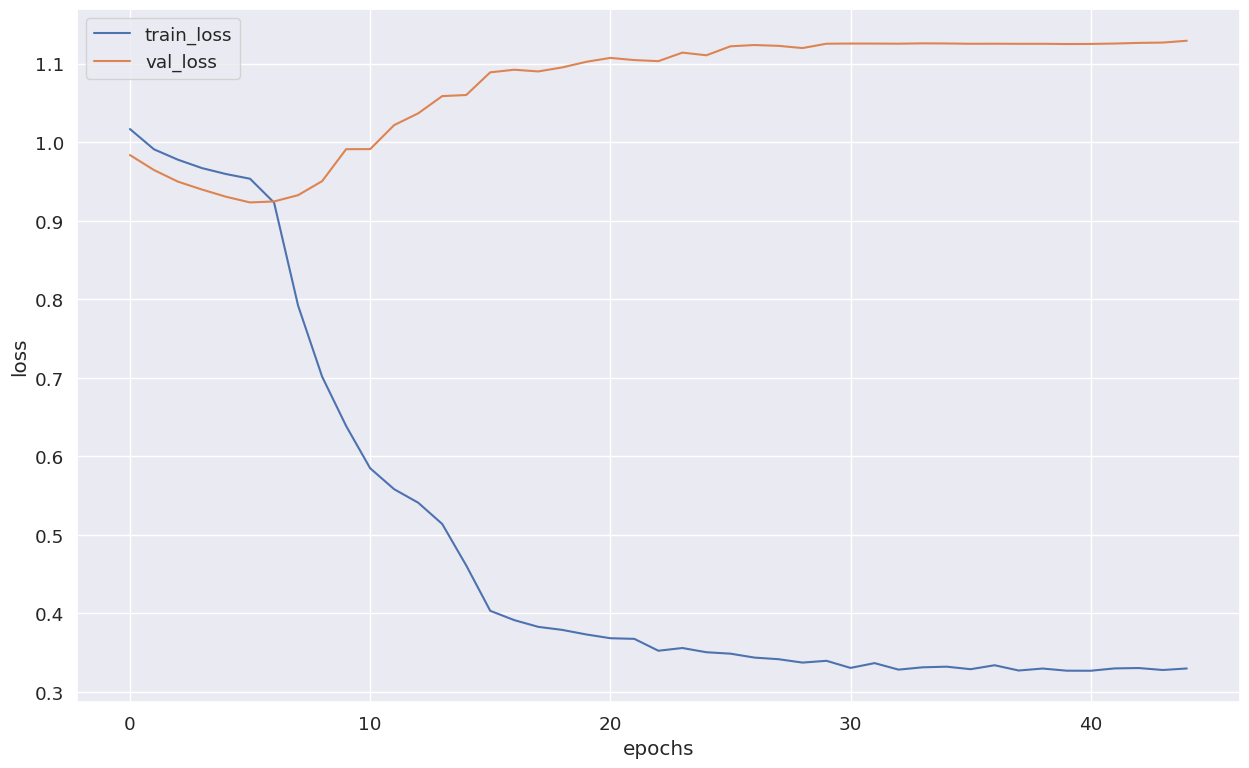

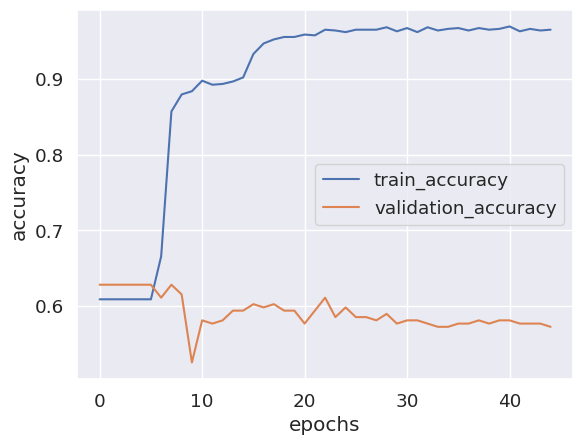

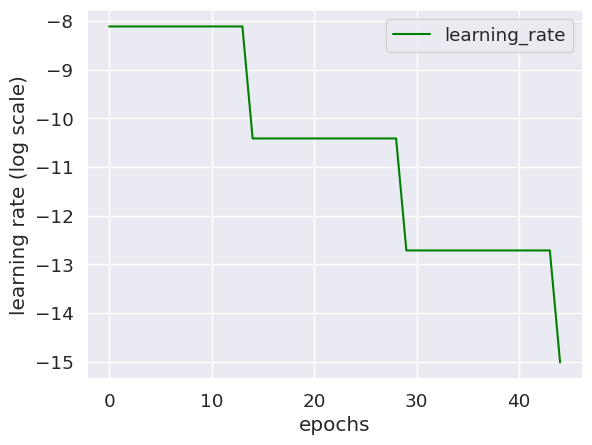

In [152]:
vizualize(graphs, 'RuBert')

In [153]:
tbert = TransformerRegrModel('rubert', 3)
model_path = "/content/drive/MyDrive/Colab Notebooks/vacancies/tiny.pt"
tbert.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
tbert.to(device)
tbert.eval()
result = predict(tbert, valid_dataloader_ru)

In [154]:
CLASSES = {'low': 0,
           'middle': 1,
           'high': 2
}

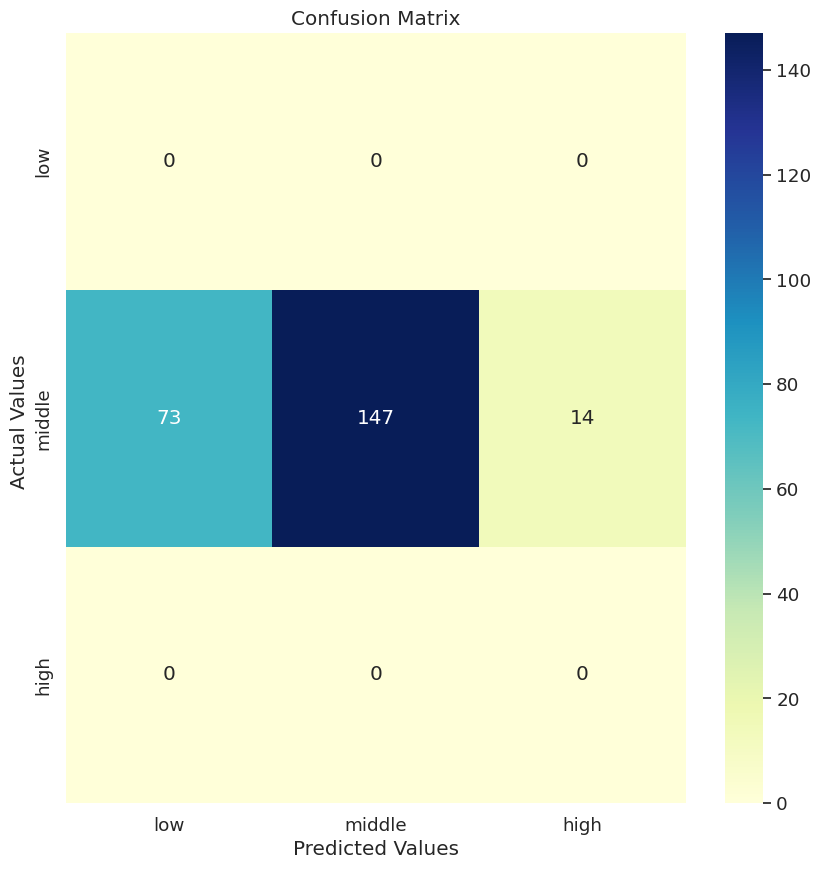

In [155]:
conf_mx = pd.DataFrame(confusion_matrix(result[1], result[0]))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='YlGnBu', ax=ax)

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(list(CLASSES.keys()))
ax.yaxis.set_ticklabels(list(CLASSES.keys()))
plt.show()

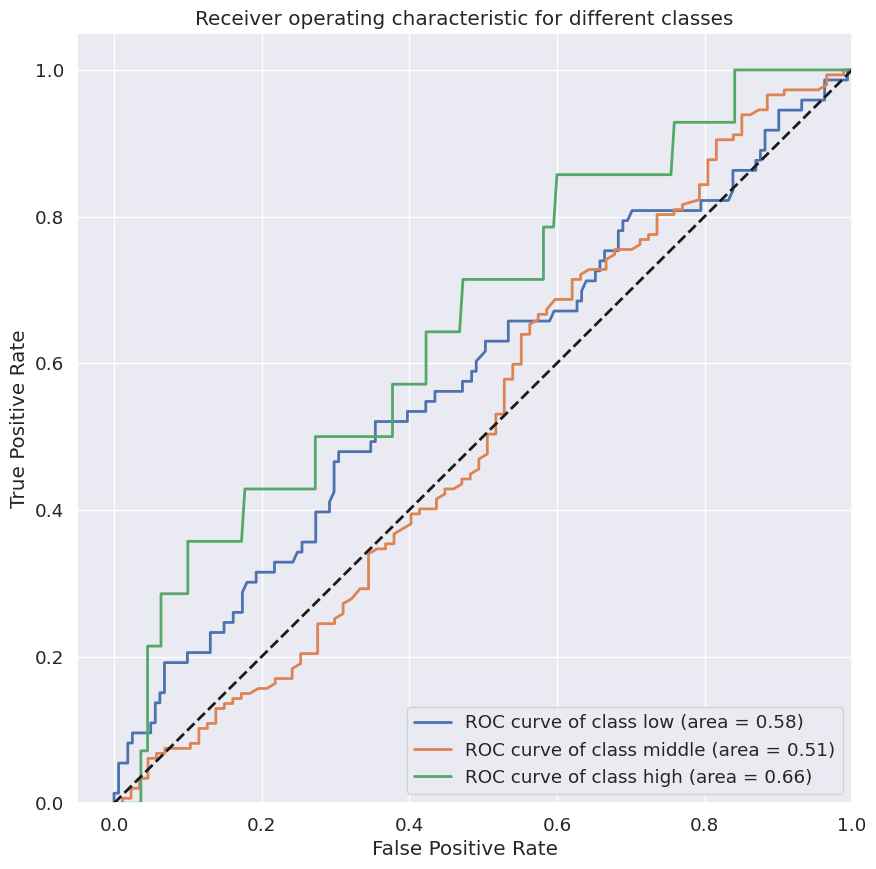

In [156]:
fig, ax = plt.subplots(figsize=(10,10))
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = list(CLASSES.values())
labels = list(CLASSES.keys())
label_test = label_binarize(result[0], classes=classes)
n_classes = label_test.shape[1]
y_score = result[2]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for different classes')
plt.legend(loc="lower right")
plt.show()

## 🐳 Результаты

**Режим обучения**

- 45 эпох
- начальная скорость 0,0003
- шедуллер 0,1 с шагом в 15 эпох

|Модель|Используемые признаки|Количество слоев классификатора|Дропаут|Заморозка|Accuracy|ROC-AUC по классам|
|-|-|-|-|-|-|-|
|tiny-bert|текстовые описания|1|нет|нет|0,63|0,59/0,56/0,61|
|tiny-bert|текстовые описания|2|нет|нет|0,60|0,54/0,50/0,58|
|tiny-bert|текстовые описания|2|0,1|нет|0,65|0,55/0,59/0,44|
|tiny-bert|текстовые описания|1|0,1|нет|0,63|0,58/0,56/0,53|
|tiny-bert|текстовые описания|1|нет|да|--|обучения не происходит|
|tiny-bert|текстовые описания + названия|1|нет|нет|0,63|0,58/0,51/0,66|
|ru-bert-base|текстовые описания + названия|1|нет|нет|обучения не происходит|--|

- 75 эпох
- начальная скорость 0,0003
- шедуллер 0,2 с шагом в 25 эпох

|Модель|Используемые признаки|Количество слоев классификатора|Дропаут|Заморозка|Accuracy|ROC-AUC по классам|
|-|-|-|-|-|-|-|
|tiny-bert|текстовые описания + названия|2|0,2|нет|||



## 🐋 CatBoost

In [64]:
def baseline(data: pd.DataFrame, columns: list, cat_features: list, target: list, save=False):
    x_train, x_val, y_train, y_val = train_test_split(data[columns], data[target], random_state=RANDOM_STATE)
    pool_train = Pool(x_train, y_train, cat_features=cat_features)
    pool_val = Pool(x_val, y_val, cat_features=cat_features)
    model = CatBoostRegressor(loss_function='RMSE')
    model.fit(pool_train, eval_set=pool_val, verbose=False, early_stopping_rounds=20)
    res = model.predict(pool_val)
    y_val["pr"] = res
    y_val["diff"] = - y_val["pr"] + y_val["target"]
    r2 = r2_score(y_val["target"], y_val["pr"])
    rmse_score = np.sqrt(mean_squared_error(y_val["target"], y_val["pr"]))
    mape_score = 100*mean_absolute_percentage_error(y_val["target"], y_val["pr"])
    plt.plot(y_val["target"], y_val["diff"], "x")
    plt.title(f'Residuals\nR2 score: {r2:.3f}\n'
              f'RMSE score: {rmse_score:.2f}\n'
              f'RMSE to target median ratio: {rmse_score / y_val["target"].median():.2f}\n'
              f'MAPE score: {mape_score:.2f} %')
    plt.show()
    importances = model.feature_importances_
    importances = pd.Series(importances, index=columns).sort_values(ascending=False)
    importances.plot.bar()
    plt.title("Feature importances")
    plt.ylabel("Mean decrease in impurity")
    plt.show()
    if save:
        name = f'{str(data.shape[0] * data.shape[1])}_cat.joblib'
        joblib.dump(model, name)

In [71]:
columns = df.columns.drop(['target', 'description', 'classes', 'description_1', 'emp_brand', 'salary_min', 'salary_max'])
target = ['target']
cat_features = ['grade', 'profession', 'location']
text = ['description', 'clean_description']

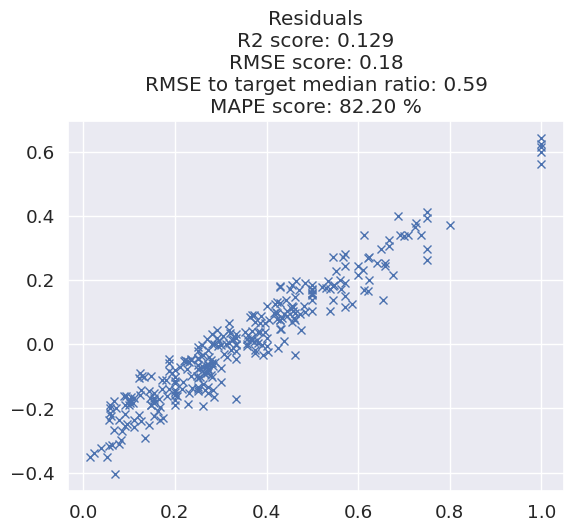

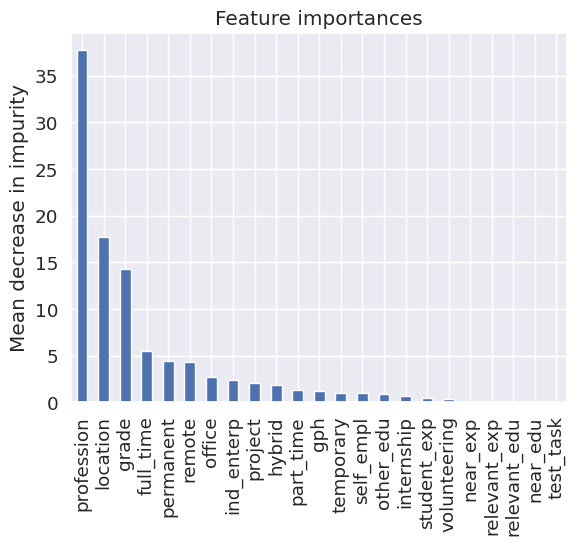

In [72]:
baseline(df, columns, cat_features, target)

In [ ]:
# df2 = pd.concat([df.reset_index(drop=True), dfe], axis=1)
# columns = df2.columns.drop(['target', 'description'])
# target = ['target']
# cat_features = ['grade', 'profession', 'location']
# text = ['description']

# baseline(df2, columns, cat_features, target)

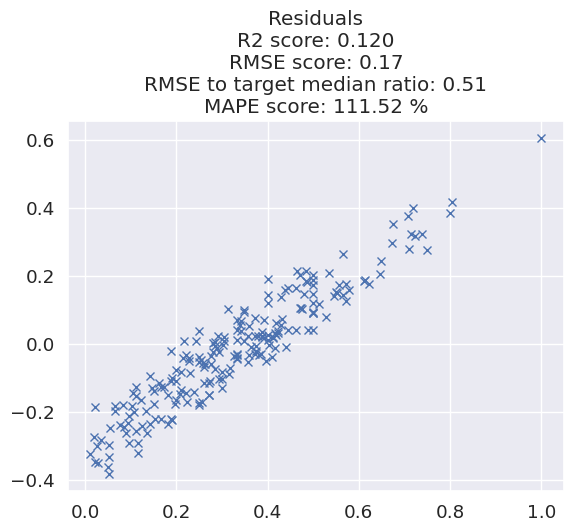

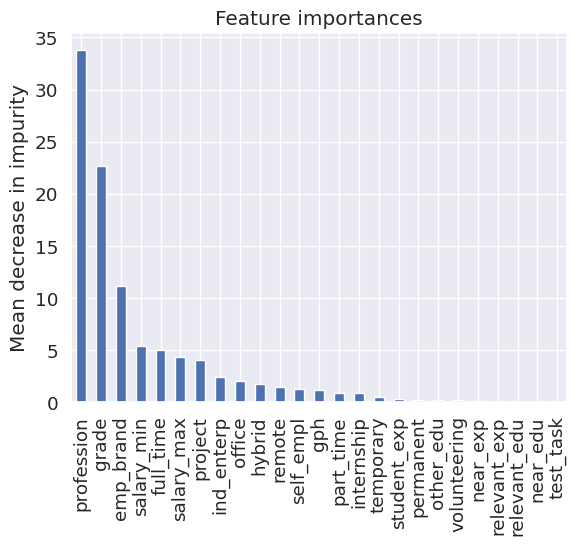

In [ ]:
df2 = df.loc[df['location'] == 'MOW']
columns = df2.columns.drop(['target', 'description', 'location'])
target = ['target']
cat_features = ['grade', 'profession', 'emp_brand']

baseline(df2, columns, cat_features, target)

In [ ]:
# for p in df['profession'].unique():
#    df1 = df.loc[df['profession'] == p]
#    columns = df1.columns.drop(['target', 'description', 'salary_min', 'salary_max', 'profession', 'location', 'grade'])
#    target = ['target']
#    cat_features = ['emp_brand']
#    print(p.upper(), '\n')
#    baseline(df1, columns, cat_features, target)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1170 entries, 0 to 1301
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   emp_brand     1170 non-null   object 
 1   salary_min    425 non-null    float64
 2   salary_max    1170 non-null   float64
 3   test_task     1170 non-null   int64  
 4   target        1170 non-null   float64
 5   grade         1170 non-null   object 
 6   profession    1170 non-null   object 
 7   location      1170 non-null   object 
 8   near_exp      1170 non-null   int64  
 9   student_exp   1170 non-null   int64  
 10  relevant_exp  1170 non-null   int64  
 11  other_edu     1170 non-null   int64  
 12  near_edu      1170 non-null   int64  
 13  relevant_edu  1170 non-null   int64  
 14  office        1170 non-null   int64  
 15  remote        1170 non-null   int64  
 16  hybrid        1170 non-null   int64  
 17  permanent     1170 non-null   int64  
 18  self_empl     1170 non-null   int

In [ ]:
df['edu_opt'] = df['other_edu'] + df['near_edu'] + df['relevant_edu']
df['exp_opt'] = df['student_exp'] + df['near_exp'] + df['relevant_exp']
df['format_opt'] = df['office'] + df['remote'] + df['hybrid']
df['contract_opt'] = df['permanent'] + df['gph'] + df['self_empl'] + df['temporary'] + df['ind_enterp']
df['time_opt'] = df['part_time'] + df['full_time'] +df['internship'] + df['volunteering'] + df['project']

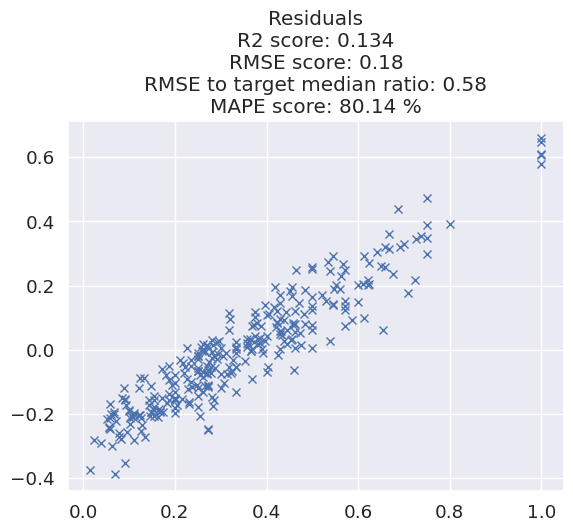

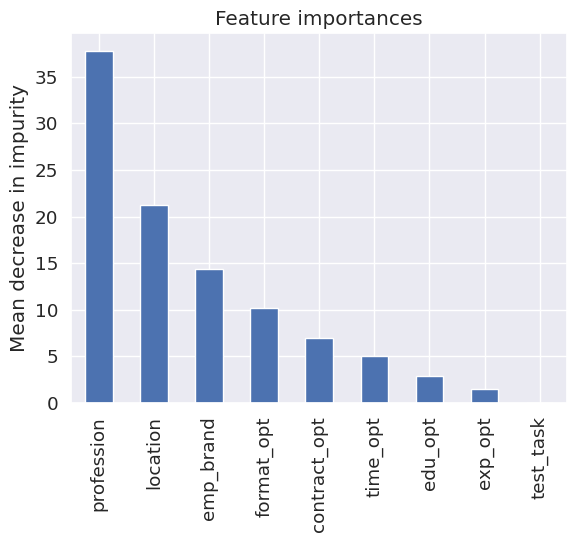

In [ ]:
columns = ['emp_brand', 'test_task',
       'profession', 'location', 'edu_opt', 'exp_opt', 'format_opt', 'contract_opt', 'time_opt']
target = ['target']
cat_features = ['profession', 'emp_brand', 'location']

baseline(df, columns, cat_features, target)

## 🐠 Выводы


- R2-score низкий
- график остатков неприятный
- добавление эмбеддингов в катбуст картину не улучшает
- рассмотрение только москвы тоже принципиально лучше не делает
- предсказания bert-ом прироста в метрике не дают
- кластеризация по профессиям - тоже